In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Clasificación I

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 15/10/2025

> Asignatura: Programación para la Inteligencia Artificial

Hasta ahora todo lo que hemos abordado han sido problemas supervisados (conocemos la entrada y la salida) y de regresión. Los problemas de regresión consisten en modelar la relación entre distintas variables dependientes para poder predecir una de ellas en función a las otras. Aprender funciones en el sentido más directo y estricto del término.

Sin embargo, no son los únicos problemas que se abordan en Aprendizaje Computacional. Un tipo de problema típico del Aprendizaje Computacional y del Aprendizaje Profundo son los problemas de clasificación.

Un problema de clasificación consiste en, dado un ejemplo (una serie de valores, una imagen, un video, etc) clasificarlo en una categoría. Asignarle una etiqueta habitualmente de entre un conjunto predefinido de opciones. Inferir si una persona está enferma o no a partir de su historial médico es un problema de clasificación en el que las categorías son *sano* y *enfermo*. Concretamente un problema de clasificación binario.

Los problemas de clasificación se dividen entre los binarios (solo dos opciones) y los multiclase (más de dos categorías). La división puede parecer arbitraria, pero las herramientas necesarias para abordar uno u otro cambian. Vamos a comenzar viendo cómo afrontar un problema de clasificación usando Aprendizaje Profundo en PyTorch.

Para empezar necesitamos un conjunto de datos. Crear un conjunto de datos artificiales para un problema de clasificación es sensiblemente más complicado que crearlo para los ejemplos de regresión, así que vamos a recurrir a los conjuntos de datos que PyTorch provee :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
workpath = '/content/drive/MyDrive/Work/Docencia UMA/2025-2026/Programacion para la IA/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dataset = datasets.MNIST(root=workpath, train=True, download=True)
test_dataset = datasets.MNIST(root=workpath, train=False, download=True)

Descargado. Como podemos ver, hemos descargado dos conjuntos de datos denominados MNIST (uno para entrenar y otro para testear). MNIST es un clásico ejemplo de jguuete, vamos a echarle un vistazo.

In [ ]:
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")
print([train_dataset[0]])

Número de ejemplos en entrenamiento: 60000
Número de ejemplos en test: 10000
[(<PIL.Image.Image image mode=L size=28x28 at 0x7EDA0B1E2AE0>, 5)]


60000 mil ejemplos de entrenamiento, 10000 de test y si observamos un ejemplo, es una tupla que contiene una imagen en el formato de la librería PIL de tamaño 28x28 con la etiqueta 5.

Vamos a cargarlo de otra manera.

In [ ]:
train_dataset = datasets.MNIST(root=workpath, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root=workpath, train=False, download=True, transform=transforms.ToTensor())

A ver ahora...

In [ ]:
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")
print([train_dataset[0]])

Número de ejemplos en entrenamiento: 60000
Número de ejemplos en test: 10000
[(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

¡Ajá! Ahora la imagen directamente es un tensor. El proceso de creación de carga nos permite aplicarle una transformación directamente. En este caso hemos elegido transforms.ToTensor() para ahorrarnos transformar nosotros la imagen en Tensor. Más cómodo para nuestros propósitos. Vamos a ver una de las imágenes.

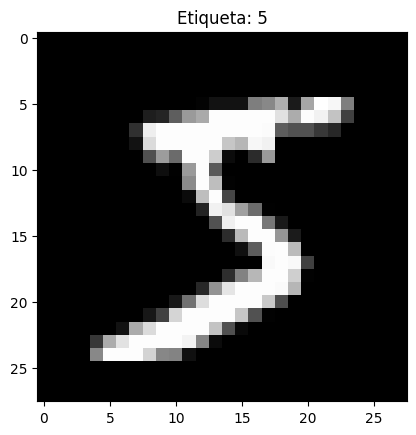

In [ ]:
image, label = train_dataset[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Etiqueta: {label}")
plt.show()

Es un número escrito a mano. MNIST es un conjunto de datos para relacionar la imagen de un número escrito a mano en blanco y negro con el número. Los números van del 0 al 9 así que hay 10 categorías. Nosotros queríamos empezar por clasificación binaria, así que vamos a quedarnos solo con un par de esas categorías. También vamos a separar los datos de test en dos subconjuntos (validación y test). Para eso vamos a crear un par de funciones.

In [ ]:
def filter_dataset(dataset, chosen_labels):
  """
  Devuelve un subconjunto del dataset que solo contiene las etiquetas especificadas.
  """
  indices = [i for i, (_, y) in enumerate(dataset) if y in chosen_labels]
  subset = torch.utils.data.Subset(dataset, indices)
  return subset

def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset


In [ ]:
labels = [1, 7]
val_dataset, test_dataset = split_dataset(test_dataset)
train_binary_dataset = filter_dataset(train_dataset, labels)
test_binary_dataset = filter_dataset(test_dataset, labels)
val_binary_dataset = filter_dataset(val_dataset, labels)

In [ ]:
print(f"Número de ejemplos en entrenamiento: {len(train_binary_dataset)}")
print(f"Número de ejemplos en validación: {len(val_binary_dataset)}")
print(f"Número de ejemplos en test: {len(test_binary_dataset)}")

Número de ejemplos en entrenamiento: 13007
Número de ejemplos en validación: 1047
Número de ejemplos en test: 1116


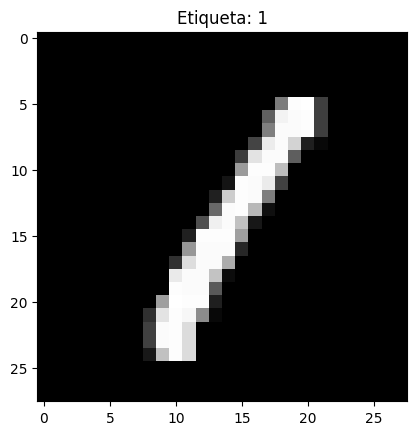

In [ ]:
image, label = train_binary_dataset[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Etiqueta: {label}")
plt.show()

Muy bien, tenemos un conjunto de datos. ¿Ahora qué? Sabemos cómo abordar un problema de regresión, una opción sería abordar el problema exactamente igual. Intentamos que ante la imagen (que no es más que números) nuestra red aprenda a devolver un número. Pero.. ¿Y si las categorías fueran animales? ¿Los transformamos en números? ¡Pues... sí! Eso ya lo veremos. Pese a que siempre transformaremos las clases en números, simplemente intentar predecir un número cualquier sin más restricción y esperar que funcione bien es demasiado *naive*. Sabemos que solo hay dos clases, ¿Por qué predecir un número cualquiera?

Vamos a empezar por rescatar nuestro bucle de entrenamiento con algunos cambios.

In [ ]:
def learning_loop_for_binary_classification(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, positive_class):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_true = y_true[:,None]                                     # Pequeño arreglo que necesitamos porque el MNIST no está pensado para clasificación binaria.
        y_true = 1*(y_true == positive_class).to(torch.float32)     # Convertimos la clase positiva en 1 y la otra en 0.
        y_pred = model(x_true)                      # Forward
        opt.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        opt.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%5==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_true = y_val_true[:,None]                                         # Pequeño arreglo que necesitamos porque el MNIST no está pensado para clasificación binaria.
            y_val_true = 1*(y_val_true == positive_class).to(torch.float32)         # Convertimos la clase positiva en 1 y la otra en 0.
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            TP = torch.sum((y_val_true>=0.5) & (y_val_pred>=0.5))
            TF = torch.sum((y_val_true<0.5) & (y_val_pred<0.5))
            correct_answers = TP+TF
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss_list.append(torch.tensor(val_step_loss_list).mean())
          val_acc_list.append(val_correct_answers/float(val_set_size))

  return model, epoch_loss_list, val_loss_list, val_acc_list

Sí, está un poco cambiado, pero básicamente hemos añadido tres cosas:

*   Incluimos un argumento para determinar cuál es la clase positiva (los 1s).
*   Con el conjunto de validación además de la pérdida almacenemos el *accuracy* (el número de aciertos).
*   La barra de progreso irá mostrando el valor de error que vamos obteniendo. No es lo más eficiente, pero es útil para tener una idea rápida de si el entrenamiento va progresando.

La idea es sencilla. En un problema de calsificación podemos tener una noción intuitiva de *acierto*. Si hay dos opciones y nuestro modelo elige la correcta, acierta. ¿Cuáles son las opciones? Como hemos dicho antes, tenemos que trabajar con números así que 0 y 1 son los valores elegidos por convención. 1 se conoce como la clase positiva y 0 la clase positiva. Nuestro modelo es muy dificil que tenga como resultado un 1 absoluto, así que asumimos que si su respuesta está más cerca del 1 que del 0 (mayor que 0.5).

Comparando los resultados con las etiquetas, ahora podemos recurrir a métricas de clasificación:

*   True Positives (TP): Número de ejemplos de la clase positiva clasificados como tal.
*   True Negatives (TN): Número de ejemplos de la clase negativa clasificados como tal.
*   False Positives (FP): Número de ejemplos de la clase negativa clasificados como positivos.
*   False Negatives (FN): Número de ejemplos de la clase positiva clasificados como negativos.

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

$$Recall = \frac{TP}{TP+FN}$$

$$Precision = \frac{TP}{TP+FP}$$

Estas métricas son recomendables para entender el comportamiento del modelo que hemos entrenado para la clasificación binaria, pero no se usan para guiar el entrenamiento en Aprendizaje Profundo porque no tiene sentido considerar ninguna de ellas para un único ejemplo, sino para un conjunto de ejemplos. El cálculo del gradiente durante el paso hacia atrás usando dichas funciones da poca información de cara a ajustar los parámetros del modelo.

Pero bueno, las funciones de pérdida basadas en la distancia como el error absoluto y el error cuadrático medio siguen teniendo sentido. Simplemente nuestros valores predichos ahroa estarán entre 0 y 1 y las etiquetas objetivo serán 0 o 1.

Podemos dar por hecho que nuestros valores estarán entre 0 y 1 porque diseñaremos un modelo neuronal con dicho comportamiento. ¿Cómo? Simplemente eligiendo una función de activación adecuada para la última capa. La sigmoide, por ejemplo, está tiene resultados justamente en el rango [0,1]. También podríamos usar la tangente hiperbólica y reescalar la salida para convertir el rango [-1,1] a [0,1].

Vamos a hacer un ejemplo en el que asignamos la clase positiva (1) a los ejemplos con etiqueta 7 y la clase negativa (0) a los ejemplos con etiqueta 1. Esta asignación es completamente arbitraria. Si fueran imágenes de perros y gatos podríamos asignar cualquiera de los dos animales como clase positiva.

In [ ]:
batch_size = 256
learning_rate = 1e-3
epochs = 51
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD
positive_class = 7                  # Decido arbitrariamente que la clase positiva serán los 7 en lugar de los 1s.

val_dataloader = DataLoader(val_binary_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_binary_dataset, batch_size = batch_size, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,1),
    torch.nn.Sigmoid()
)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_binary_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    positive_class=positive_class)

Número de parámetros 50305


epoch:: 100%|██████████| 51/51 [01:38<00:00,  1.92s/it, loss=0.20055720210075378]


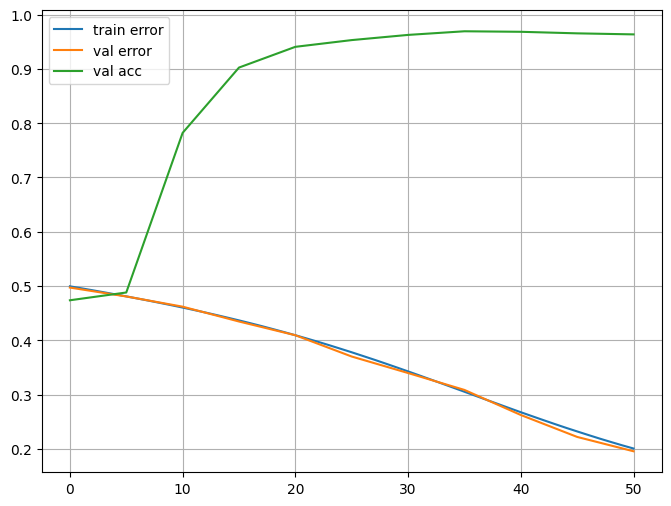

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(epochs), train_loss_list, label="train error")
plt.plot(range(0,epochs,5), val_loss_list, label="val error")
plt.plot(range(0,epochs,5), val_acc_list, label="val acc")
plt.legend()
plt.grid(True)
plt.show()

Vamos a ver también la matriz de confusión.

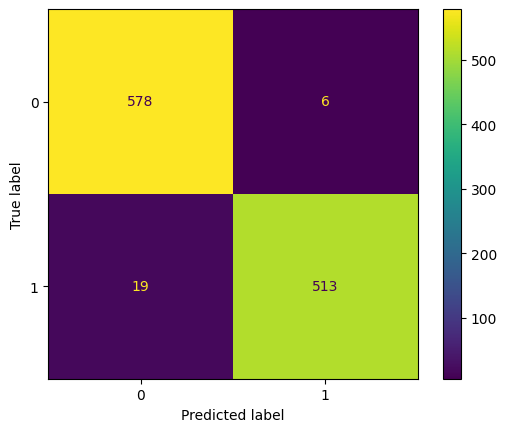

In [ ]:
test_dataloader = DataLoader(test_binary_dataset, batch_size=batch_size, shuffle=True)

y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  y_test.append(1*(val_y_true==positive_class))
  y_pred.append(model(val_x_true).detach())

y_test = torch.cat(y_test)
y_pred = torch.cat(y_pred) > 0.5
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Podemos ver que el *accuracy* del conjunto de validación aumenta a un valor muy cercano al 1 mientras el error disminuye. Sin embargo, el error no llega a bajar de 0.4. Nuestro modelo funciona bastante bien. Acierta más del 95% de las veces, pero nuestra función de error no lo refleja. ¿Por qué? Bueno, aceptamos como clasificación positiva cualquier valor que supere el 0.5 (técnicamente también el 0.5) y como clasificación negativa cualquier valor menor que 0.5. Un resultado de 0.51 es tan bueno para clasificar un ejemplo de la clase positiva como un 0.99 (y así lo evalúa el *accuracy*), pero para el error absoluto es un error de 0.49. Para ese mismo ejemplo un resultado de 0.48 es un error de falso negativo, pero para el error absoluto es un error de 0.52. Una diferencia crucial en la clasificación para el error absoluto no supone prácticamente una diferencia.

Aunque un error basado en la distancia funcione en un problema tan sencillo como el que estamos trabajando, no es especialmente bueno caracterizando las propiedades de un problema de clasificación.

Por eso vamos a plantear una función de error que caracteriza mejor un problema binario como la entropia cruzada binaria (*Binary Cross Entropy* o BCE a partir de ahora).

$$BCE(y_{pred}, y_{true}) = -(y_{true}log(y_{pred})+(1-y_{true})log(1-y_{pred}))$$

Vamos a ver el comportamiento de esta función. Si suponemos un caso en el que la clasificación es perfecta ($y_{pred} = y_{true}$), si la clasificación es positiva ($y_{pred} = y_{true}=1$), el primer término de la ecuación es $log(1)=0$ mientras que el segundo término es $0log(0)=(0)(-∞)$. Si la clasificación es negativa  ($y_{pred} = y_{true}=0$) los resultados de los términos se intercambian. Con una clasificación diametralmente incorrecta ($y_{pred} = 1$  con $y_{true}=0$ o $y_{pred} = 0$  con $y_{true}=1$) uno de los términos es $-\infty$. En todos estos casos aparece un valor de $\infty$ debido a la asíntota de la función logarítimca. Esto es un problema desde el punto de vista del análisis matemático... pero para nuestros propósitos no lo es tanto. En la práctica PyTorch limita (función **clamp** en Pytorch y **clip** en TensorFlow) el valor de ese logaritmo para que no de valores menores de -100. Si cambiamos  los $-\infty$ por -100 podemos observar que cuando la clasificación es perfecta, la función BCE tiene como resultado 0, mientras que cuando la calsificación es totalmente incorrecta tiene como resultado 100.

Vamos a observar la evolución del BCE en la práctica comparado con el error cuadrático y el absoluto según se aleja de la clasificación ideal.



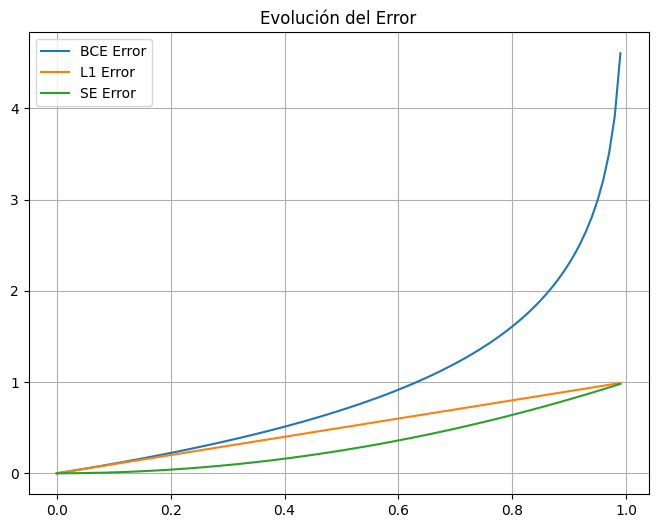

In [ ]:
bce = torch.nn.BCELoss(reduction='none')
l1 = torch.nn.L1Loss(reduction='none')
se = torch.nn.MSELoss(reduction='none')

x = torch.linspace(0.00,0.99,100)
target = torch.zeros_like(x)
bce_error = bce(x, target)
l1_error = l1(x, target)
se_error = se(x, target)

plt.figure(figsize=(8,6))
plt.plot(x, bce_error, label="BCE Error")
plt.plot(x, l1_error, label="L1 Error")
plt.plot(x, se_error, label="SE Error")
plt.legend()
plt.title("Evolución del Error")
plt.grid(True)
plt.show()

Nota: Calculamos el error solo hasta 0.99 simplemente para que la gráfica no llegue hasta el 100 e impida apreciar los otros errores.

Nota 2: la *reduction* de la función de error indica a PyTorch cómo "reducir" los resultados de todos los ejemplos a uno solo. Por defecto suele ser la media, pero también podría ser la suma o, como en este caso, ninguna para que devuelva los resultados de la función para cada ejemplo proporcionado.

El error absoluto crece de manera constante. Conceptualmente penaliza igual una diferencia entre 0.2 y 0.4 que una diferencia entre 0.4 y 0.6 (su pendiente es constante). Sin embargo, para el problema que estamos trabajando sabemos que la diferencia entre 0.2 y 0.4 nos importa mucho menos que la dieferencia entre 0.4 y 0.6. El error cuadrático sí que aumenta la penalización del error cuánto mayor es (la inclinación incrementa), aunque entre 0 y 1 el aumento no es especialmente grande. La BCE muestra un incremento de la curva aún mayor.

Vamos a aprovechar para reflexionar sobre cómo afecta la función de error al aprendizaje. Como hemos dicho previamente, nuestro ajuste se basa en el gradiente del error respecto a los parámetros ajustables del modelo que produce ese error. Calcular el gradiente durante el paso hacia atrás (*backward*) implica aplicar la regla de la cadena y el gradiente respecto a los parámetros va a tener siempre la forma:

$$\nabla L(m_{\mathbf{w}}(x))= (\frac{∂L(m_{\mathbf{w}}(x))}{∂w_{1}},...,\frac{∂L(m_{\mathbf{w}}(x))}{∂w_{n}}) = (\frac{∂L(m_{\mathbf{w}}(x))}{∂m_{\mathbf{w}}(x)}\frac{∂m_{\mathbf{w}}(x)}{∂w_{1}},...,\frac{∂L(m_{\mathbf{w}}(x))}{∂m_{\mathbf{w}}(x)}\frac{∂m_{\mathbf{w}}(x)}{∂w_{n}})$$

dado un modelo $m_{\mathbf{w}}$ con los parámetros ajustables $\mathbf{w}=(w_{1},...,w_{n}))$. Todas las componentes del vector gradiente están multiplicados por $\frac{∂L(m_{\mathbf{w}}(x))}{∂m_{\mathbf{w}}(x)}$ que es la derivada de la función de error respecto al resultado del modelo.

Con lo cuál es relevante cómo evoluciona la derivada de la función de error según el error de clasificación aumenta. Vamos a hacer una pequeña chapuza (porque PyTorch no está pensado para esto) para obtener el gradiente únicamente de la función de error según este aumenta desde una predicción correcta ($y_{pred} = 0$  con $y_{true}=0$) a una totalmente incorrecta ($y_{pred} = 1$  con $y_{true}=0$).

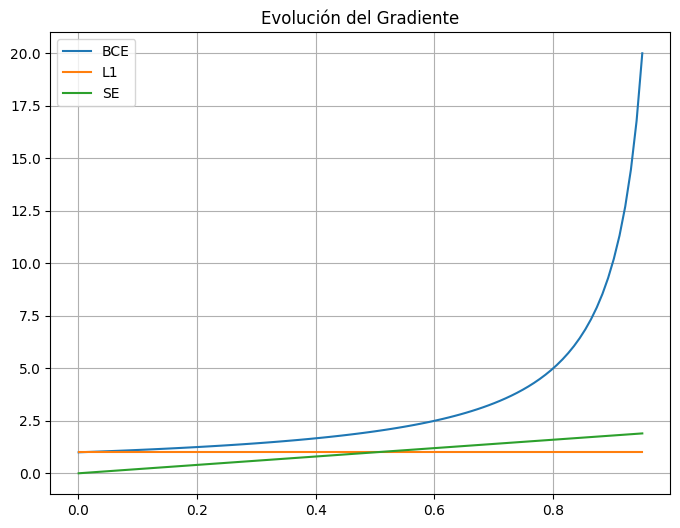

In [ ]:
bce = torch.nn.BCELoss()
l1 = torch.nn.L1Loss()
se = torch.nn.MSELoss()

bce_grad_list = []
l1_grad_list = []
se_grad_list = []

x = torch.linspace(0.001,0.95,100)
for fake_output in x:
  fake_output.requires_grad_(True)
  target = torch.zeros_like(fake_output)

  bce_error = bce(fake_output, target)
  bce_error.backward()
  bce_grad = fake_output.grad.clone()
  bce_grad_list.append(bce_grad)
  fake_output.grad.zero_()

  l1_error = l1(fake_output, target)
  l1_error.backward()
  l1_grad = fake_output.grad.clone()
  l1_grad_list.append(l1_grad)
  fake_output.grad.zero_()

  se_error = se(fake_output, target)
  se_error.backward()
  se_grad = fake_output.grad.clone()
  se_grad_list.append(se_grad)
  fake_output.grad.zero_()

x = x.detach()
plt.figure(figsize=(8,6))
plt.plot(x, bce_grad_list, label="BCE")
plt.plot(x, l1_grad_list, label="L1")
plt.plot(x, se_grad_list, label="SE")
plt.legend()
plt.title("Evolución del Gradiente")
plt.grid(True)
plt.show()

Nota: una vez más restringimos el rango para favorecer la visibilidad de la gráfica.

El gradiente del error absoluto es una constante. Es lo esperable en una función que para casos positivos es una recta de inclinación 1. Su derivada es la constante 1. Esto nos indica que si la clasificación correcta es 0, da igual si nuestro modelo indica 0.2, 0.7 o 1, el factor que multiplicará las derivadas paricales del modelo será $\frac{∂L(m_{\mathbf{w}}(x))}{∂m_{\mathbf{w}}(x)}=1$ para todos los casos.  

El gradiente del error cuadrático es ahora una recta de inclinación 2. Consecuencia de que $x^2 dx = 2x$. El factor que multiplicará las derivadas parciales del modelo no será el mismo si nuestro modelo indica 0.2 (menor que 1), 0.5 (exactamente 1) o 1 (exactamente 2). Dado un lote de 2 ejemplos ($x_{1}$ y $x_{2}$) en los que el modelo $m_{\mathbf{w}}$ tiene resultados 0.5 y 1 respectivamente. Si la clasificación correcta es 0, la derivada del error en esos puntos será $\frac{∂L(m_{\mathbf{w}}(x_{1}))}{∂m_{\mathbf{w}}(x_{1})}=1$ y $\frac{∂L(m_{\mathbf{w}}(x_{2}))}{∂m_{\mathbf{w}}(x_{2})}=2$. Eso haría que las derivadas parciales del modelo en el punto $x_{2}$ para el gradiente tengan el "doble de influencia" en el gradiente final. Esto tiene sentido si queremos priorizar la dirección de ajuste que indica el gradiente de los ejemplos con los que nuestro modelo funciona peor.

Está lógica nos interesa especialmente en la clasificación binaria. Que nuestro modelo dictamine 0.2 cuando debería decir 0 sigue siendo acertar, por lo que corregir en base a su gradiente nos interesa menos que corregir en base a los ejemplos en los que dictamina mayor que 0.5.

Observando la evolución del gradiente de la BCE, sabemos que se dará mucha más importancia a los ejemplos con clasificaciones muy lejanas a la ideal.

Vamos a ver qué tal sale un entrenamiento utilizando la BCE:

In [ ]:
batch_size = 256
learning_rate = 1e-3
epochs = 51
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD
positive_class = 7                      # Decidoa rbitrariamente que la clase positiva (1) va a ser el número 7.

val_dataloader = DataLoader(val_binary_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_binary_dataset, batch_size = batch_size, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,1),
    torch.nn.Sigmoid()
)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_binary_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    positive_class=positive_class)

Número de parámetros 50305


epoch:: 100%|██████████| 51/51 [01:36<00:00,  1.90s/it, loss=0.13816949725151062]


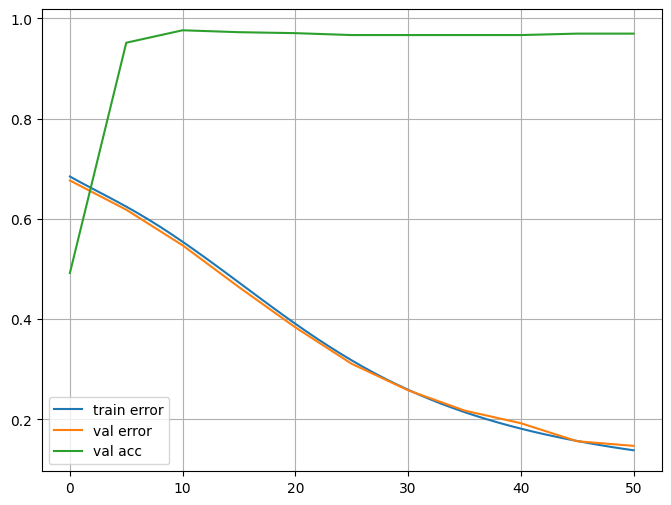

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(epochs), train_loss_list, label="train error")
plt.plot(range(0,epochs,5), val_loss_list, label="val error")
plt.plot(range(0,epochs,5), val_acc_list, label="val acc")
plt.legend()
plt.grid(True)
plt.show()

Es importante señalar que las medidas de error entre los dos entrenamientos no son comparables porque se han calculado con funciones distitnas y, aunque los dos parecen funcionar bien, resulta interesante ver cómo el *accuracy* crece más rápido usando la BCE. Ese fenómeno es el esperable porque los ejemplos mal clasificados (que es lo que mide el accuracy) tienen mucha más importancia usando BCE.

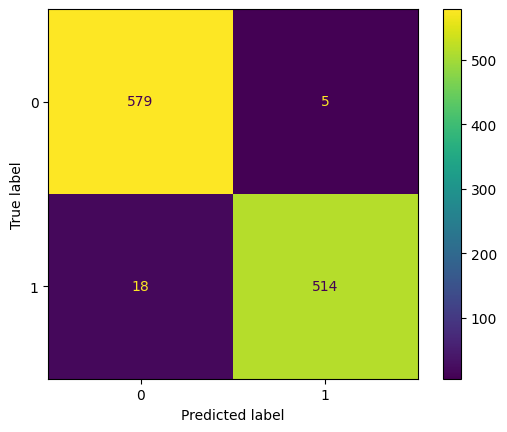

In [ ]:
test_dataloader = DataLoader(test_binary_dataset, batch_size=batch_size, shuffle=True)

y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  y_test.append(1*(val_y_true==positive_class))
  y_pred.append(model(val_x_true).detach())

y_test = torch.cat(y_test)
y_pred = torch.cat(y_pred) > 0.5
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Entonces... ¿qué función de pérdida usamos para clasificación binaria? Ambas han funcionado bien para este problema. Sin embargo, en problema más complicados suele ser recomendable usar la BCE sobre MSE o L1. Aún así, lo importante es comprender por qué BCE se ajusta mejor a este tipo de problema.

Además, para el siguiente tema es importante comprender la estrategia aplicada en clasificación binaria de entrenar nuestro modelo para que porporcione un valor entre 0 y 1. Un valor que, aunque con reservas, podríamos interpretar como la probabilidad que el modelo dictamina de que un ejemplo pertenezca a la clase positiva.